## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (168773, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 1000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 1000 steps
Generated time-series
Normalized 'candles_norm' with shape : (1000, 9)
Feature data 'x_candles' with size : 952
Feature data with time intervals 'x_time' with size : 952


In [6]:
USE_PRETRAINED = True
PRESAVED_MODELDATE='220615_18_16'
initial_timestamp = pd.Timestamp(datetime.strptime('220615_18_16', '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
preds = ts_btc.denorm(loaded_model.preds)

In [7]:
delta = can_btc.candles.index[1] - can_btc.candles.index[0]
series_dates = can_btc.candles.index.shift(1,freq = delta)

,Low,High,Open,vol_diff,Volume,UpperBB,LowerBB,price2volratio,Close
Date,,,,,,,,,
2017-08-17 06:31:00,4319.83,4345.45,4328.65,-0.006737,3.494176,4354.619977,4264.944023,4.808001,4345.45
2017-08-17 06:46:00,4324.35,4345.45,4345.45,-3.324938,0.169238,4345.916804,4286.227196,-124.676491,4324.35
2017-08-17 07:01:00,4316.62,4316.62,4316.62,-0.167697,0.001541,4346.272361,4287.181639,0.000000,4316.62
2017-08-17 07:16:00,4291.38,4291.38,4291.38,0.037377,0.038918,4348.406850,4281.557150,0.000000,4291.38
2017-08-17 07:31:00,4291.39,4300.00,4291.39,0.679983,0.718901,4348.690957,4280.411043,11.976614,4300.00
...,...,...,...,...,...,...,...,...,...
2022-06-15 23:16:00,22545.33,22686.81,22605.74,-149.401380,738.686340,22962.966324,21693.467676,0.021958,22621.96
2022-06-15 23:31:00,22467.49,22639.86,22621.96,-21.775160,716.911180,22920.755967,21875.380033,-0.165237,22503.50
2022-06-15 23:46:00,22468.09,22606.68,22503.50,-67.353590,649.557590,22865.257940,22066.880060,0.123499,22583.72


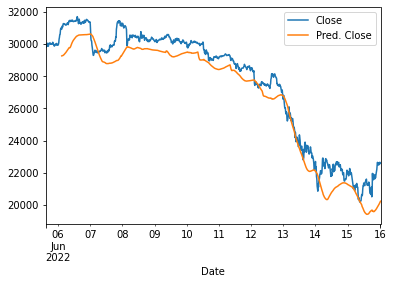

In [14]:
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred. Close",shifted_time_indexes,top_or_bottom="bottom")
df_compare = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_compare.iloc[-1000:].plot()